# Compute metrics for different runs and plot them
##### author: Elizabeth A. Barnes, Randal J. Barnes and Mark DeMaria
##### version: v0.3.0

In [1]:
import datetime
import os
import pickle
import pprint
import time

import experiment_settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from build_data import build_hurricane_data
import model_diagnostics
import prediction
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

dpiFig = 400

mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
__author__ = "Randal J Barnes and Elizabeth A. Barnes"
__version__ = "18 March 2022"

EXP_NAME_LIST = (
                 "intensity302_EPCP48",    
                 "intensity312_EPCP48",    
                 "intensity322_EPCP48",        
                 )

APPEND_NAME = ''#'_paper'

DATA_PATH = "data/"
MODEL_PATH = "saved_models/"
METRIC_PATH = "saved_metrics/"
FIGURE_PATH = "figures/paper_figures/"
PREDICTION_PATH = "saved_predictions/"

## Code for plots

In [3]:
FS = 16

### for white background...
plt.rc('text',usetex=True)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Avant Garde']}) 
plt.rc('savefig',facecolor='white')
plt.rc('axes',facecolor='white')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('xtick',color='dimgrey')
plt.rc('ytick',color='dimgrey')
################################  
################################  
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([]) 

def format_spines(ax):
    adjust_spines(ax, ['left', 'bottom'])
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('dimgrey')
    ax.spines['bottom'].set_color('dimgrey')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
#     ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)    
    

## Get the dataframe

In [4]:
df_metrics = pd.DataFrame()

for exp_name in EXP_NAME_LIST:
    settings = experiment_settings.get_settings(exp_name)

    # set testing data
    if settings["test_condition"] == "leave-one-out":
        TESTING_YEARS_LIST = np.arange(2013,2022)
    elif settings["test_condition"] == "years":
        TESTING_YEARS_LIST = (np.copy(settings["years_test"]))
    else:
        raise NotImplementError('no such testing condition')
        
        
    for testing_years in TESTING_YEARS_LIST:        
        # set testing year
        settings["years_test"] = (testing_years,)
    
    
        for rng_seed in settings["rng_seed_list"]:
            settings['rng_seed'] = rng_seed
            NETWORK_SEED_LIST = [settings["rng_seed"]]
            network_seed = NETWORK_SEED_LIST[0]
    
            model_name = (
                exp_name + "_" + 
                str(testing_years) + '_' +
                settings["uncertainty_type"] + '_' + 
                f"network_seed_{network_seed}_rng_seed_{settings['rng_seed']}"
            )

            # load the metric filename
            metric_filename = METRIC_PATH + model_name + '_metrics.pickle'  
            if os.path.exists(metric_filename)==False:
                print(metric_filename + ' DOES NOT exist. Skipping...')
                continue

            # pprint.pprint(model_name)
            df = pd.read_pickle(metric_filename)
            # df['basin_lead'] = exp_name[exp_name.rfind('_')+1:]

            df_metrics = pd.concat([df_metrics,df])
df_metrics

,uncertainty_type,network_seed,rng_seed,exp_name,pit_D_test,iqr_capture_test,iqr_error_spearman_test,iqr_error_pearson_test,iqr_error_spearman_p_test,iqr_error_pearson_p_test,...,iqr_error_spearman_p_valtest,iqr_error_pearson_p_valtest,cons_error_valtest,mean_error_valtest,median_error_valtest,mode_error_valtest,mean_error_reduction_valtest,median_error_reduction_valtest,mode_error_reduction_valtest,basin_lead
0,shash3,416,416,intensity4_EPCP48,0.029107,0.475000,0.428919,0.419547,1.019815e-06,1.844317e-06,...,1.026901e-12,2.440455e-14,13.374063,12.053299,11.876791,12.212187,1.320765,1.497272,1.161876,EPCP48
0,shash3,222,222,intensity4_EPCP48,0.035746,0.500000,0.513230,0.556680,2.049565e-09,4.053417e-11,...,1.139025e-18,8.266703e-18,11.782499,11.118172,10.972540,11.173750,0.664327,0.809959,0.608749,EPCP48
0,shash3,598,598,intensity4_EPCP48,0.030957,0.525000,0.560282,0.511410,2.853336e-11,2.387235e-09,...,1.283357e-20,2.540190e-20,11.440625,10.348824,10.083656,10.083750,1.091801,1.356969,1.356875,EPCP48
0,shash3,731,731,intensity4_EPCP48,0.034359,0.558333,0.582638,0.581634,2.928789e-12,3.255947e-12,...,1.143739e-14,4.270868e-14,12.715625,10.929502,10.841758,11.320625,1.786123,1.873866,1.395000,EPCP48
0,shash3,414,414,intensity4_EPCP48,0.035158,0.558333,0.485159,0.449939,1.956418e-08,2.526631e-07,...,3.694954e-12,8.994346e-12,11.631874,10.711850,10.465592,10.706875,0.920024,1.166282,0.924999,EPCP48
0,shash3,187,187,intensity4_EPCP48,0.030276,0.566667,0.507049,0.474813,3.428153e-09,4.274653e-08,...,5.962189e-16,1.938338e-17,12.633125,10.924639,10.781091,11.367500,1.708486,1.852034,1.265625,EPCP48
0,shash3,650,650,intensity4_EPCP48,0.042817,0.583333,0.438989,0.453872,5.288021e-07,1.925587e-07,...,1.724310e-12,9.542933e-11,12.583438,11.042451,10.879636,11.351563,1.540987,1.703802,1.231875,EPCP48
0,shash3,891,891,intensity4_EPCP48,0.039791,0.541667,0.463171,0.489498,9.992815e-08,1.398648e-08,...,9.376767e-18,1.006060e-16,12.247812,11.604899,11.529015,11.650313,0.642913,0.718798,0.597500,EPCP48
0,shash3,739,739,intensity4_EPCP48,0.026352,0.500000,0.296618,0.426752,1.003176e-03,1.171417e-06,...,1.150025e-09,3.200273e-10,12.907187,11.176970,10.880424,11.373437,1.730216,2.026762,1.533749,EPCP48
0,shash3,241,241,intensity4_EPCP48,0.037081,0.500000,0.561247,0.569994,2.595227e-11,1.083813e-11,...,6.009612e-19,4.231513e-19,12.876562,11.792552,11.680428,11.869688,1.084010,1.196134,1.006875,EPCP48


## Figure for main paper

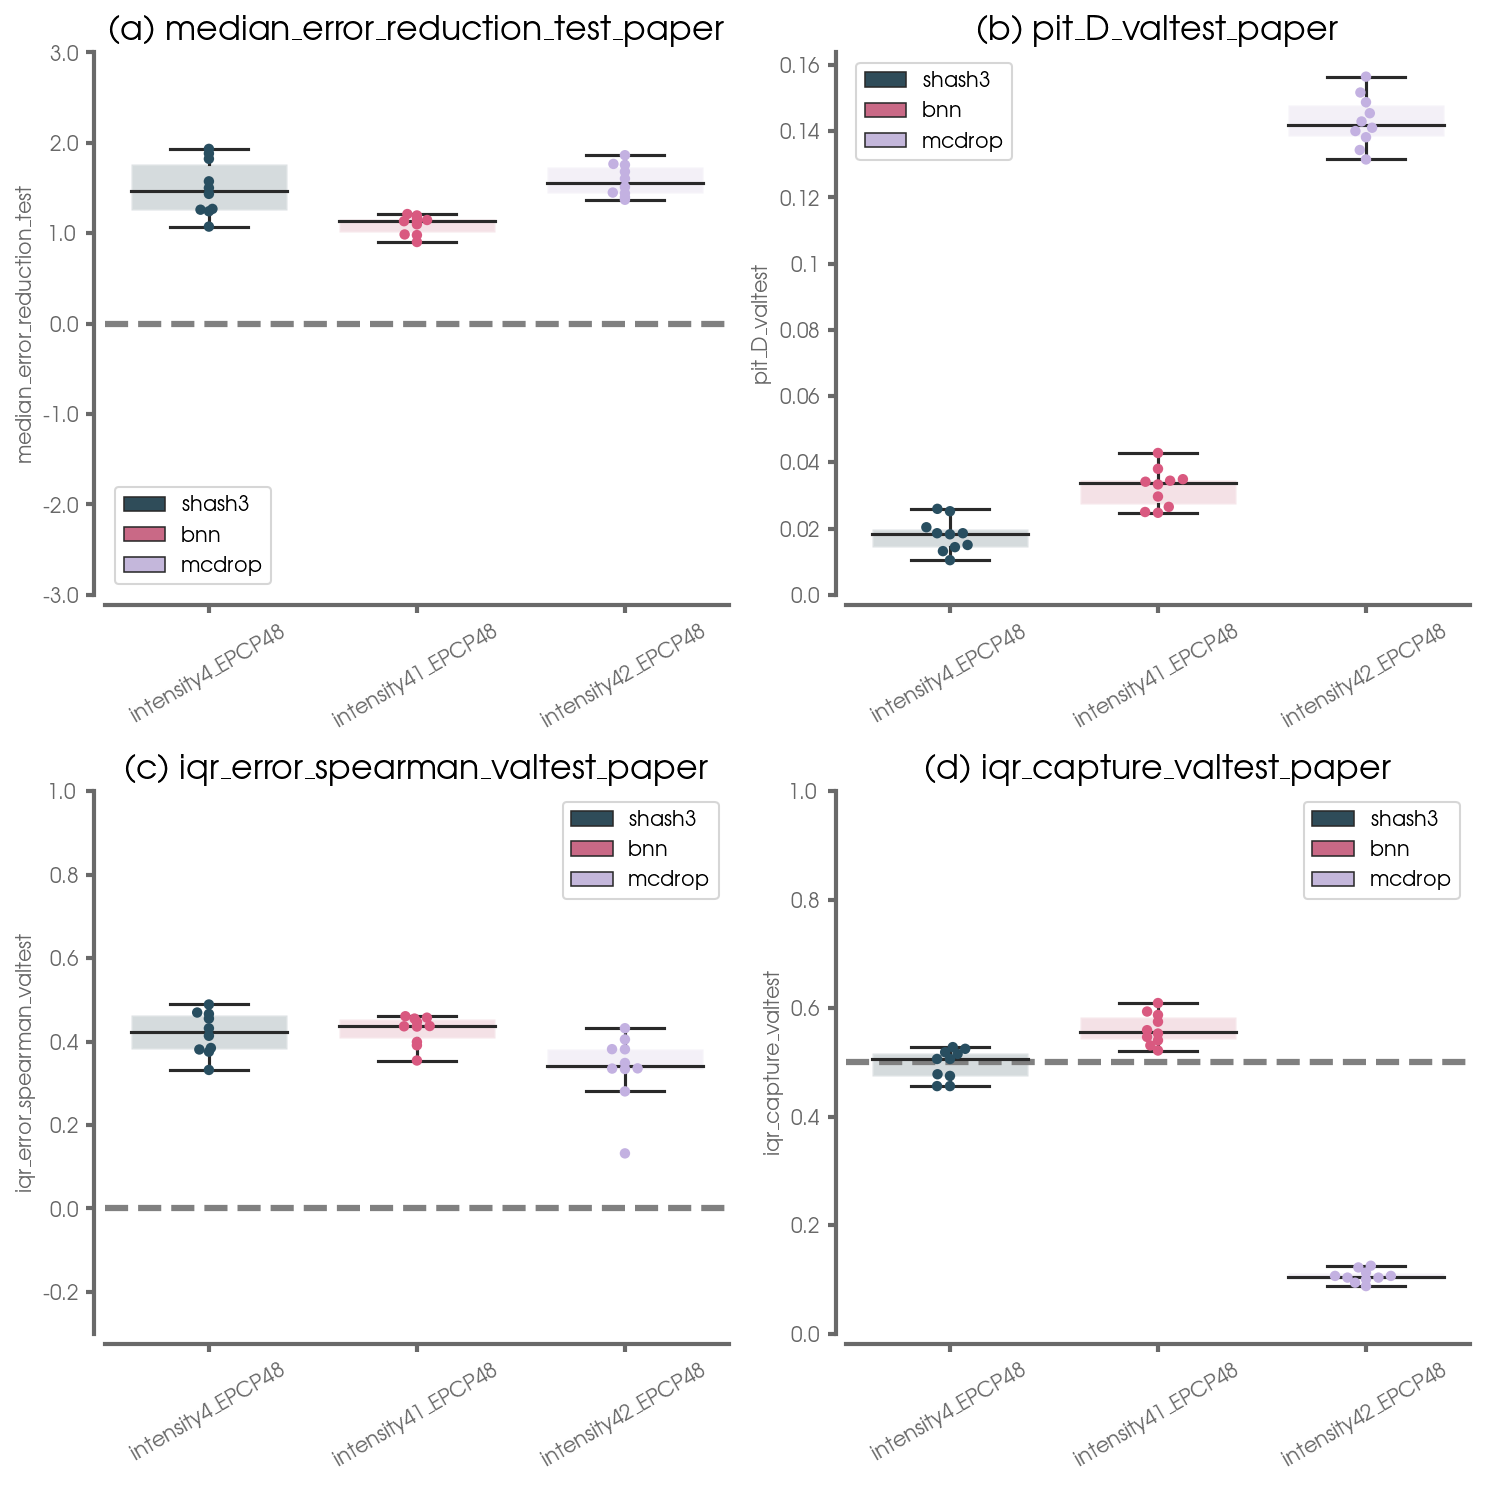

In [9]:
import seaborn as sns
colors = ('#284E60','#D95980','#C3B1E1')#('#284E60','#E1A730','#D95980','#C3B1E1','#351F27','#A9C961')
panel_letters = ('(a)','(b)','(c)','(d)')
x_axis_list = ("exp_name",)#("basin_lead", "exp_name")

metric_data = ''
metric_list = ('median_error_reduction_test',
               'pit_D_valtest',
               'iqr_error_spearman_valtest',                                                                     
               'iqr_capture_valtest',
              )

for x_axis in x_axis_list:
    f, axs = plt.subplots(2, 2, figsize=(10,10))
    axs = axs.flatten()
    
    for imetric, metric in enumerate([m + metric_data for m in metric_list]):
        ax = axs[imetric]
        g1 = sns.boxplot(x=x_axis, 
                         y=metric, 
                         hue="uncertainty_type",
                         data=df_metrics,
                         palette=colors,
                         width=.75,
                         dodge=False,                    
                         boxprops={'alpha':.2,
                                   'edgecolor': 'white',
                                  },
                         fliersize=0,
                         ax=ax)
        g2 = sns.swarmplot(x=x_axis, 
                           y=metric, 
                           hue="uncertainty_type",
                           palette=colors,
                           data=df_metrics, 
                           dodge=False,
                           ax=ax)
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[:3], labels[:3],fontsize=10,frameon=True)
        
        if(metric.find('iqr_capture') > -1):
            ax.axhline(y=0.5,linewidth=3,linestyle='--',color='gray')
            ax.set_ylim(0,1.0)
        if(metric.find('pit_D') > -1):
            ax.set_ylim(0,None)
        if(metric.find('reduction') > -1):
            ax.axhline(y=0.0,linewidth=3,linestyle='--',color='gray')
            ax.set_ylim(-3.,3.)
        if(metric.find('reduction') == -1 and metric.find('n_error') > -1):
            ax.set_ylim(0.,22.)
        if(metric.find('iqr_error')> -1):
            ax.set_ylim(-.3,1.)
            ax.axhline(y=0.0,linewidth=3,linestyle='--',color='gray')        

        ax.set_title(panel_letters[imetric] + ' ' + metric + APPEND_NAME,
                     fontsize=FS,
                     color='k',
                    )
        # ax.get_legend().remove()
        x_tick_labels = ax.get_xticklabels()
        ax.set_xticklabels(x_tick_labels,rotation = 30)
        yticks = np.around(ax.get_yticks(),3)
        ax.set_yticklabels(yticks)       
        
        format_spines(ax)
        ax.set_xticklabels(x_tick_labels,rotation = 30)
        ax.set_xlabel('')
        
    plt.tight_layout()    
    plt.savefig(FIGURE_PATH + 'uq_comparisonsMetrics' + APPEND_NAME + '.png', dpi=dpiFig)    
    # plt.close()
    plt.show()

In [6]:
for exp_name in df_metrics["exp_name"].unique():
    df_show = df_metrics.loc[df_metrics["exp_name"]==exp_name][["exp_name",
                                                                "network_seed", 
                                                                "mode_error_reduction_val",
                                                                "median_error_reduction_val",
                                                               ]]
    display(df_show)

,exp_name,network_seed,mode_error_reduction_val,median_error_reduction_val
0,intensity4_EPCP48,416,1.029000,1.649831
0,intensity4_EPCP48,222,0.210001,0.534411
0,intensity4_EPCP48,598,1.540000,1.414899
0,intensity4_EPCP48,731,1.381000,1.868733
0,intensity4_EPCP48,414,0.766999,0.965257
0,intensity4_EPCP48,187,1.149001,1.869185
0,intensity4_EPCP48,650,1.120999,1.781460
0,intensity4_EPCP48,891,0.356000,0.288739
0,intensity4_EPCP48,739,0.845000,2.082871
0,intensity4_EPCP48,241,1.157001,1.269702


,exp_name,network_seed,mode_error_reduction_val,median_error_reduction_val
0,intensity41_EPCP48,416,0.724637,0.681166
0,intensity41_EPCP48,222,0.687215,0.592479
0,intensity41_EPCP48,598,0.583803,0.675419
0,intensity41_EPCP48,731,1.039229,1.060874
0,intensity41_EPCP48,414,-0.094090,0.011869
0,intensity41_EPCP48,187,0.863151,0.911181
0,intensity41_EPCP48,650,1.093417,1.243337
0,intensity41_EPCP48,891,-0.052854,0.188629
0,intensity41_EPCP48,739,1.499842,1.502674
0,intensity41_EPCP48,241,0.610710,0.527680


,exp_name,network_seed,mode_error_reduction_val,median_error_reduction_val
0,intensity42_EPCP48,416,1.016935,1.143291
0,intensity42_EPCP48,222,0.750674,0.753784
0,intensity42_EPCP48,598,0.713627,0.731992
0,intensity42_EPCP48,731,1.720134,1.837435
0,intensity42_EPCP48,414,0.431259,0.408302
0,intensity42_EPCP48,187,1.254869,1.338878
0,intensity42_EPCP48,650,1.624111,1.721966
0,intensity42_EPCP48,891,0.518923,0.515999
0,intensity42_EPCP48,739,1.685424,1.791045
0,intensity42_EPCP48,241,1.014677,1.110985
